In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import polars as pl
import gc

# Data Reading


In [2]:
# Parquet 파일을 읽기
# polar를 활용하여 3번째 까지만 읽어옴

for i in range(0,4,1):
    df = pl.read_parquet(f'datasets/train.parquet/partition_id={i}')
    globals()[f'df_{i + 1}'] = df


In [3]:

df_tmp_total = pl.concat([df_1, df_2, df_3])
df_tmp_total.shape


(7785330, 92)

In [4]:
'''
day_1 = df_tmp_total.filter(pl.col("date_id") == 1)
day_1
'''

'\nday_1 = df_tmp_total.filter(pl.col("date_id") == 1)\nday_1\n'

In [5]:
symbols_per_day = df_tmp_total.group_by("date_id").agg([pl.col("symbol_id").n_unique().alias("nb_symbols")])
symbols_per_day = symbols_per_day.sort('date_id')

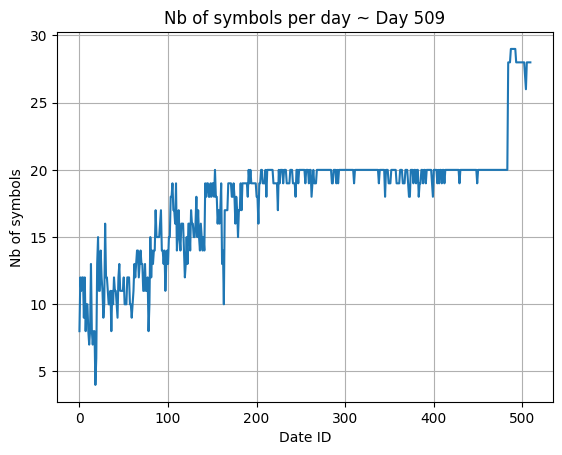

In [6]:
x = symbols_per_day["date_id"].to_numpy()
y = symbols_per_day["nb_symbols"].to_numpy()

plt.plot(x, y)
plt.xlabel("Date ID")
plt.ylabel("Nb of symbols")
plt.title("Nb of symbols per day ~ Day 509")
plt.grid()
plt.show()

# Visualization for Responses

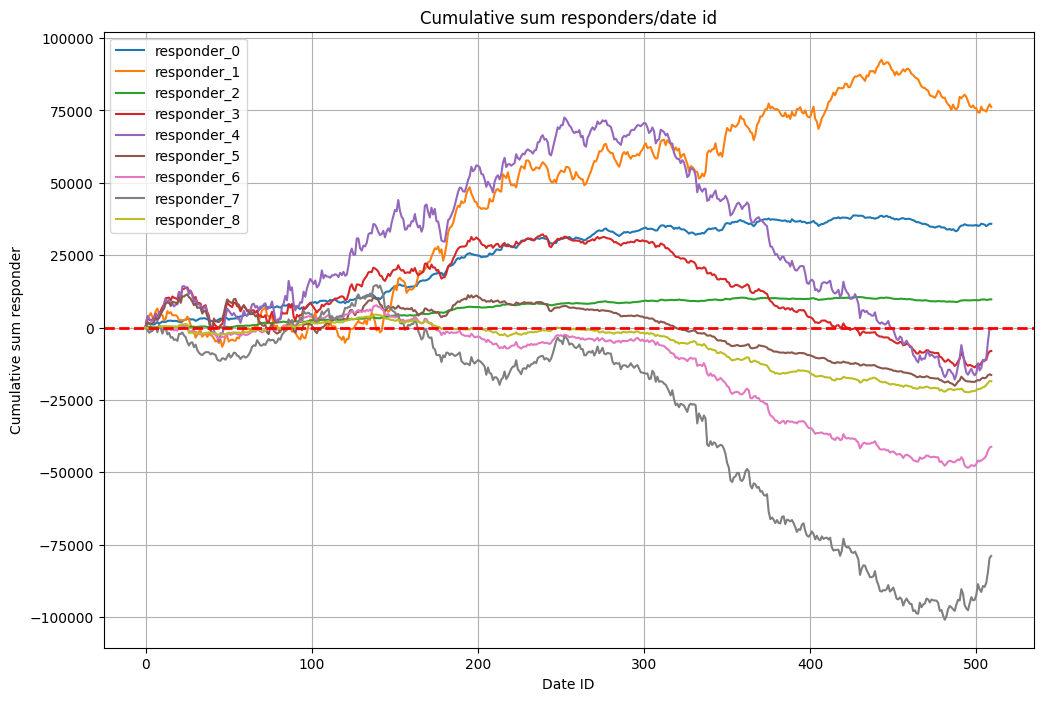

In [7]:
plt.figure(figsize=(12, 8))
for i in range(0,9):
    resp = df_tmp_total.group_by("date_id").agg(pl.col(f"responder_{i}").sum().alias("responder_sum"))
    resp = resp.sort('date_id')
    
    x = resp["date_id"].to_numpy()
    y = np.cumsum(resp['responder_sum'].to_numpy())

    plt.plot(x, y, label=f'responder_{i}')

plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Date ID")
plt.ylabel("Cumulative sum responder")
plt.title("Cumulative sum responders/date id")  
plt.grid()
plt.legend()
plt.show()

In [8]:
# responder들 가져요기
df_tmp_resp = df_tmp_total[:,83:92]

# 첫 번째 행의 date_id 가져오기
date_id_value = df_tmp_total["date_id"]  # 첫 번째 행의 date_id 값 가져오기

# date_id 값을 새로운 열로 추가
df_tmp_resp = df_tmp_resp.with_columns(
    pl.lit(date_id_value).alias("date_id")  # date_id 열 추가
)

df_tmp_resp.head(3)

responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,date_id
f32,f32,f32,f32,f32,f32,f32,f32,f32,i16
0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0
2.965889,1.190077,-0.523998,3.849921,2.626981,5.0,0.703665,0.216683,0.778639,0
-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828,0


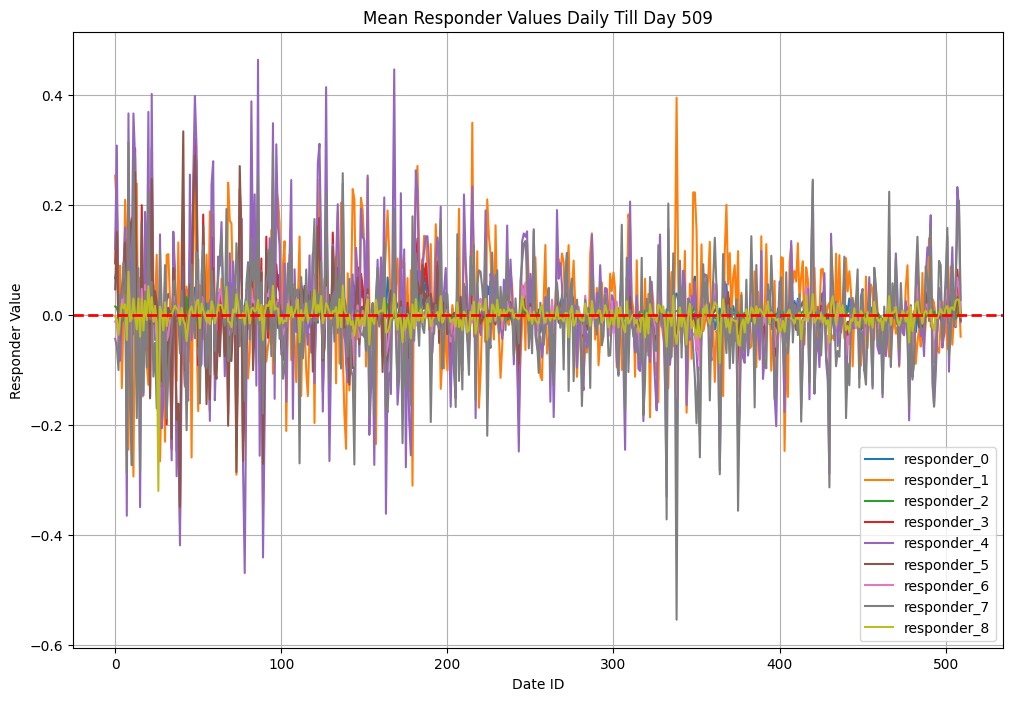

In [9]:
plt.figure(figsize=(12, 8))

# 일별로 responder의 평균 구하기
resp = df_tmp_total.group_by('date_id').agg([pl.col(f"responder_{i}").mean().alias(f"mean_responder_{i}") for i in range(9)]).sort('date_id')

for i in range(0,9):
    
    x = resp["date_id"].to_numpy()
    y = resp[f"mean_responder_{i}"].to_numpy()

    plt.plot(x, y, label=f'responder_{i}')

plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Date ID")
plt.ylabel("Responder Value")
plt.title("Mean Responder Values Daily Till Day 509")  
plt.grid()
plt.legend()
plt.show()

# 계층적 군집화
- 결측치 처리가 문제다.

In [10]:
# build datareading model
def read_data(num_f, num_s = 0):
    dfs = []
    for i in range(num_s,num_f):
        df = pl.read_parquet(f'datasets/train.parquet/partition_id={i}')
        dfs.append(df)

    df_total = pl.concat(dfs)
    return df_total

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture

def plot_dendrogram(data, popcol = None):
    """
    Polars 데이터 프레임의 feature들 간 유클리드 거리 기반으로 덴드로그램을 그리는 함수.

    Parameters:
    - data: polars DataFrame, 덴드로그램을 그릴 데이터 (date_id 열을 포함해야 함)
    """
    # feature 데이터만 선택 (date_id 제외)
    if popcol is not None:
        data = data.drop(f'{popcol}')
    else:
        pass
    
    features = data

    # 데이터를 numpy 배열로 변환
    feature_names = features.columns
    feature_array = features.to_numpy()

    # 계층적 군집화 수행
    linked = linkage(feature_array.transpose(), method='ward',metric='euclidean')  # 행이 아닌 열 기준으로 군집화

    # 덴드로그램 그리기
    plt.figure(figsize=(12, 8))
    dendrogram(
        linked,
        orientation='top',
        labels=feature_names,  # feature 이름을 레이블로 사용
        distance_sort='descending',
        show_leaf_counts=False
    )
    plt.title('Dendrogram (Columns)')
    plt.xticks(rotation = 45)
    plt.xlabel('Columns')
    plt.ylabel('Distance')
    plt.show()

# 클러스터링 모집
# 군집 갯수를 조정하기 쉽게 함수화
def perform_hierarchical_clustering(data, n_clusters=4): 
    # 계층적 군집화 수행

    # feature 데이터만 선택 (date_id 제외)
    features = data.drop("date_id")

    # 데이터를 numpy 배열로 변환
    feature_names = features.columns
    feature_array = features.to_numpy()
       
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = hierarchical.fit_predict(feature_array)
    
    # 덴드로그램 시각화
    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(feature_array.transpose(), method='ward', metric='euclidean')
    dendrogram(linkage_matrix, labels=feature_names,)
    plt.title('계층적 군집화 덴드로그램')
    plt.xlabel('샘플 인덱스')
    plt.ylabel('거리')
    plt.show()

    return clusters

def date_and_resp(df_tmp_total):
    # responder들 가져요기
    df_tmp_resp = df_tmp_total[:,83:92]

    # 첫 번째 행의 date_id 가져오기
    date_id_value = df_tmp_total["date_id"]

    # date_id 값을 새로운 열로 추가
    df_tmp_resp = df_tmp_resp.with_columns(
        pl.lit(date_id_value).alias("date_id")  # date_id 열 추가
    )

    return df_tmp_resp

def date_and_feature(df_tmp_total):
    # responder들 가져요기
    df_tmp_feat = df_tmp_total[:,4:83]

    # 첫 번째 행의 date_id 가져오기
    date_id_value = df_tmp_total["date_id"]  

    # date_id 값을 새로운 열로 추가
    df_tmp_feat = df_tmp_feat.with_columns(
        pl.lit(date_id_value).alias("date_id")  # date_id 열 추가
    )

    return df_tmp_feat

def sample_df_small(df):
    df_sampled = df.sample(n=2000000, with_replacement=False)
    return df_sampled

In [12]:
# define early_model and late_model

df_early_model = read_data(2)
df_mid_model = read_data(6, num_s = 4)
df_late_model = read_data(10, num_s = 8)

In [13]:
# make date and resp datasets

df_early_resp_compressed = sample_df_small(date_and_resp(df_early_model))
df_mid_resp_compressed = date_and_resp(df_mid_model)
df_late_resp_compressed = date_and_resp(df_late_model)

In [14]:
df_early_feat_compressed = sample_df_small(date_and_resp(df_early_model))
df_mid_feat_compressed = date_and_resp(df_mid_model)
df_late_feat_compressed = date_and_resp(df_late_model)

# Dendrogram by Responders

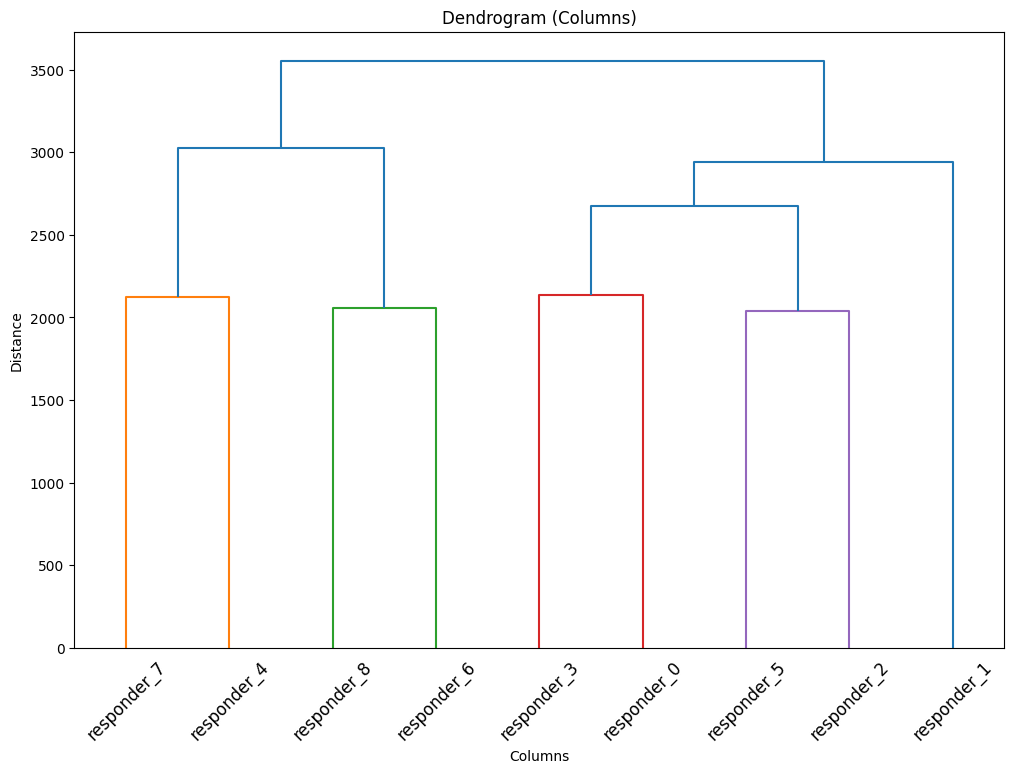

In [15]:
plot_dendrogram(date_and_resp(df_early_model), popcol='date_id')

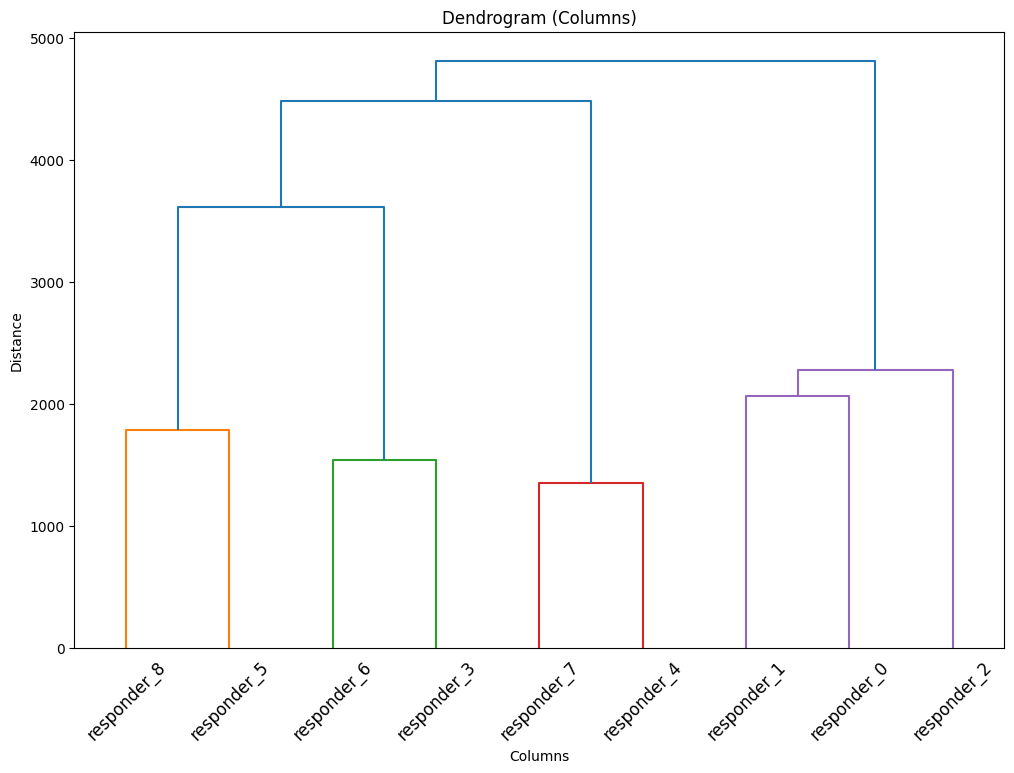

In [16]:
plot_dendrogram(date_and_resp(df_mid_model), popcol='date_id')

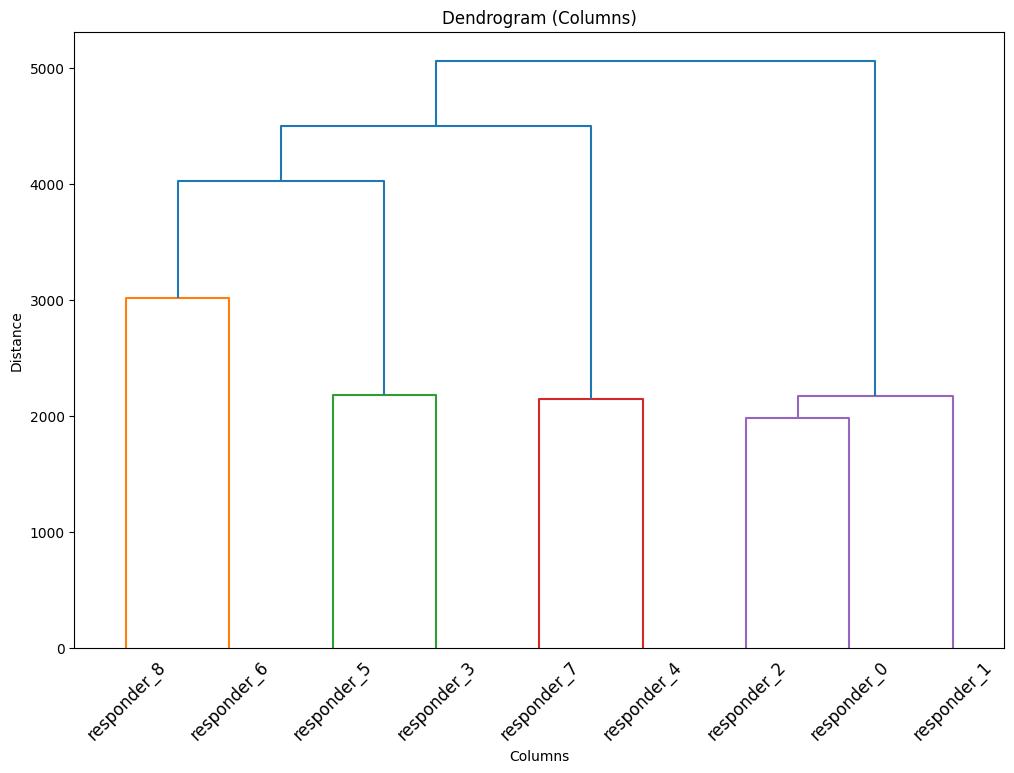

In [17]:
plot_dendrogram(date_and_resp(df_late_model), popcol='date_id')

## Dendrogram by Feature - Cancelled

In [18]:
# 임시 

def plot_dendrogram_nullprocess(data):
    """
    Polars DataFrame의 feature 열들을 기반으로 유클리드 거리로 덴드로그램을 그리는 함수.
    금융 실시간 데이터를 고려하여 결측치를 적절히 처리함.

    Parameters:
    - data: polars DataFrame, 덴드로그램을 그릴 데이터 (date_id 열은 제외)
    """
    # 'date_id' 열 제외한 feature만 선택
    features = data.drop('date_id')

    # 결측치 처리 (선형 보간법 사용, 금융 데이터에 적합)
    features = features.with_columns([
        pl.col(col).fill_null(pl.col(col).mean()).fill_null(0) for col in features.columns  
    ])

    # 데이터를 numpy 배열로 변환
    feature_names = features.columns
    data_array = features
    
    # 계층적 군집화 수행
    linked = linkage(data_array.transpose(), method='ward', metric='euclidean')

    # 덴드로그램 그리기
    plt.figure(figsize=(12, 8))
    dendrogram(
        linked,
        orientation='top',
        labels=feature_names,  # feature명을 레이블로 사용
        distance_sort='descending',
        show_leaf_counts=True
    )
    plt.title('Dendrogram (Features)')
    plt.xlabel('Features')
    plt.ylabel('Euclidean Distance')
    plt.show()

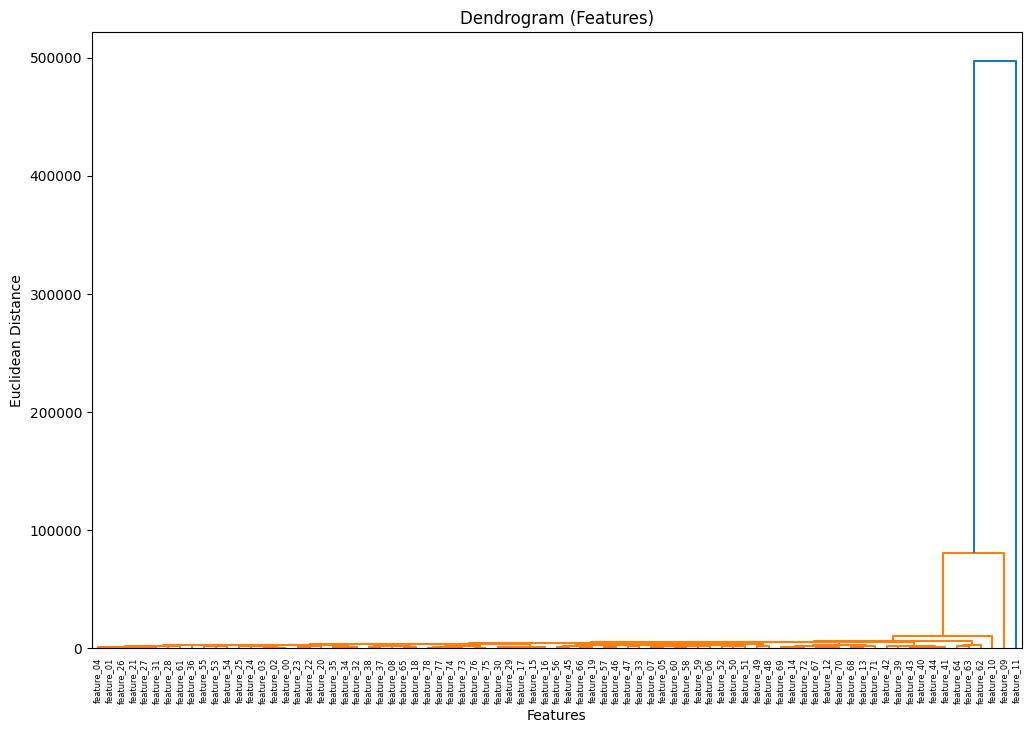

In [19]:
# feature에는 결측치가 존재한다는 게 문제다.

df_early = sample_df_small(date_and_feature(df_early_model))
plot_dendrogram_nullprocess(df_early)

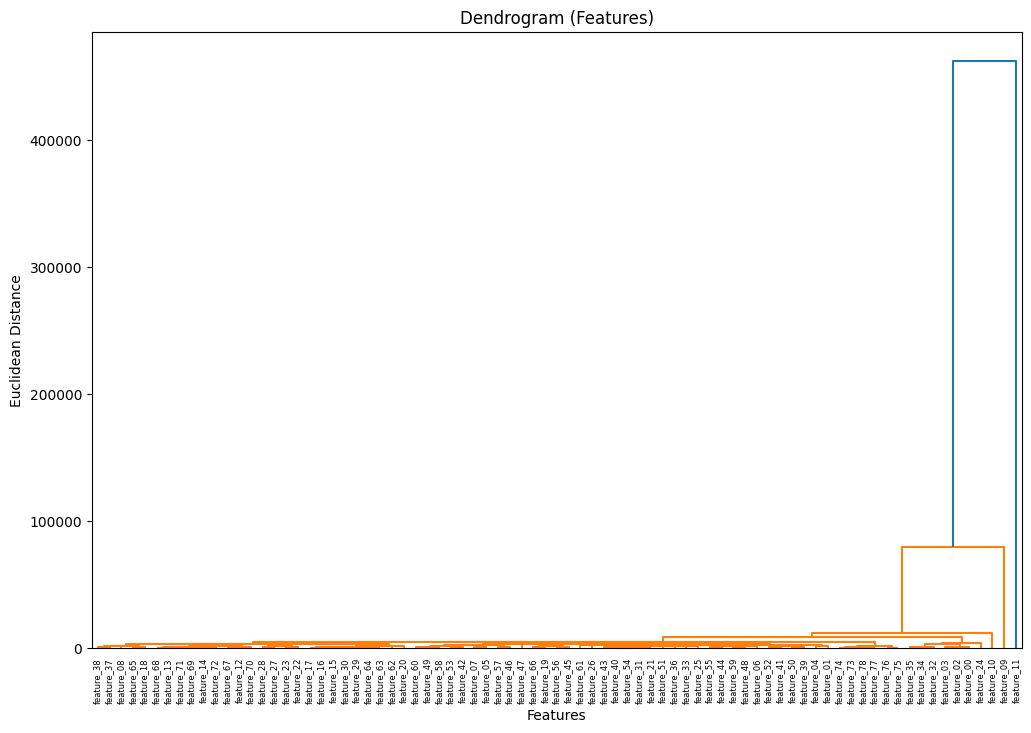

In [20]:
df_late = sample_df_small(date_and_feature(df_late_model))
plot_dendrogram_nullprocess(df_late)

# Deeper look at Features

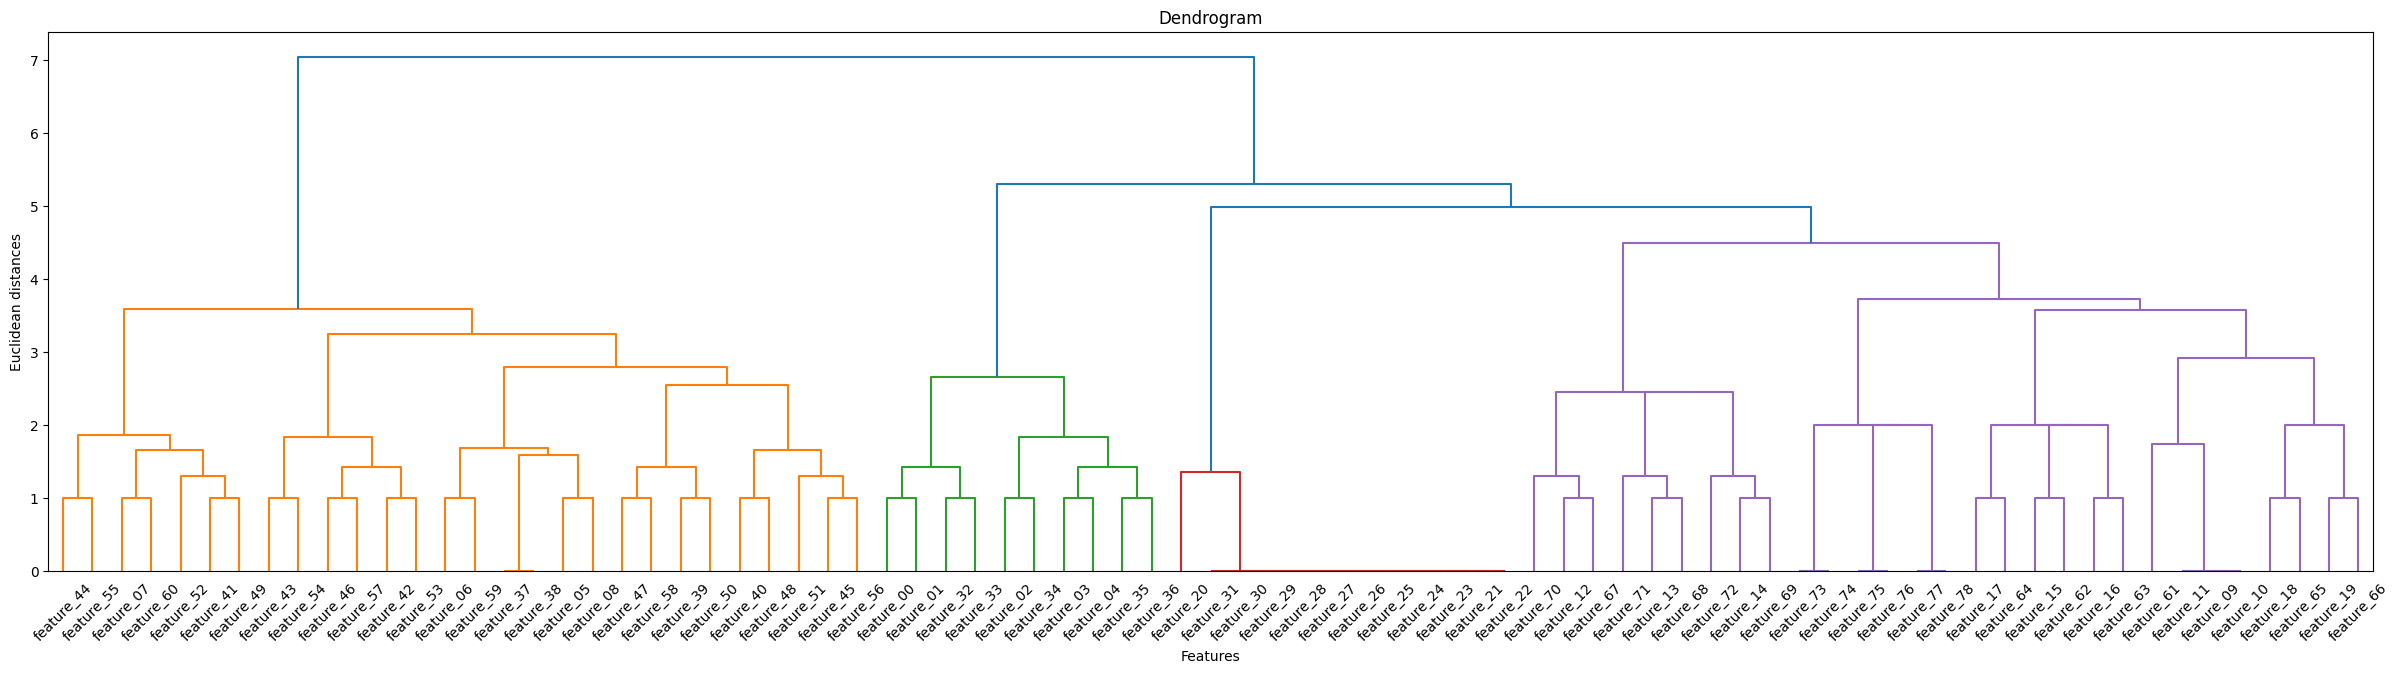

In [21]:
import scipy.cluster.hierarchy as sch

# 데이터 로드
features_tags = pd.read_csv('datasets/features.csv')

# 데이터 준비
f_names = features_tags.pop('feature')  # 'feature' 열 제거
#features_tags = features_tags.fillna(0)  # 결측값 처리 (필요 시 조정)

# 덴드로그램 그리기
plt.figure(figsize=(30, 7))
linked = sch.linkage(features_tags, method='ward')  # 계층적 클러스터링 (워드 방법 사용)

sch.dendrogram(linked, labels=f_names.values, orientation='top', leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram')
plt.xlabel('Features')
plt.xticks(rotation = 45)
plt.ylabel('Euclidean distances')
plt.show()

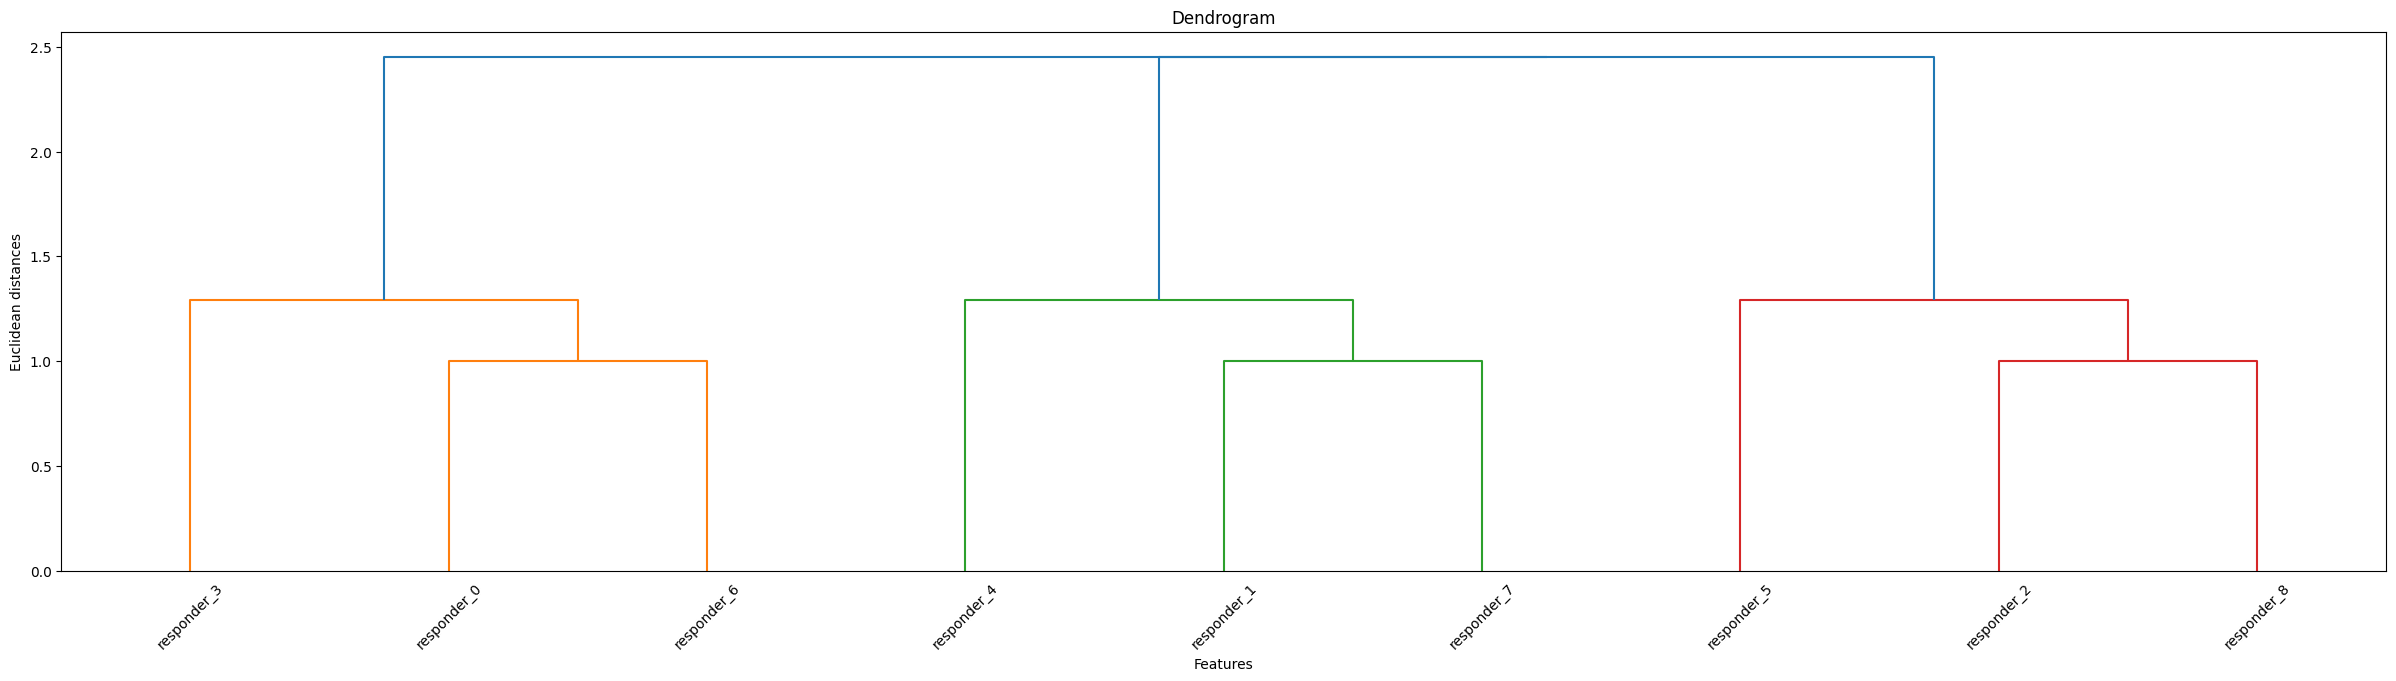

In [22]:
# 데이터 준비
responders_tags = pd.read_csv('datasets/responders.csv')
r_names = responders_tags.pop('responder')  # 'feature' 열 제거
#features_tags = features_tags.fillna(0)  # 결측값 처리 (필요 시 조정)

# 덴드로그램 그리기
plt.figure(figsize=(30, 7))
linked = sch.linkage(responders_tags, method='ward')  # 계층적 클러스터링 (워드 방법 사용)

sch.dendrogram(linked, labels=r_names.values, orientation='top', leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram')
plt.xlabel('Features')
plt.xticks(rotation = 45)
plt.ylabel('Euclidean distances')
plt.show()

In [23]:
# Computer Buster
'''
responders_columns = ["feature_" + f"{i:02}" for i in range(79)]

dfs = []

for i in range(0,10,1):
    df = pl.read_parquet(f'datasets/train.parquet/partition_id={i}', columns=responders_columns)
    dfs.append(df)
    

df_feat_total = pl.concat(dfs)
df_feat_total.shape
'''

'\nresponders_columns = ["feature_" + f"{i:02}" for i in range(79)]\n\ndfs = []\n\nfor i in range(0,10,1):\n    df = pl.read_parquet(f\'datasets/train.parquet/partition_id={i}\', columns=responders_columns)\n    dfs.append(df)\n    \n\ndf_feat_total = pl.concat(dfs)\ndf_feat_total.shape\n'

In [34]:
import polars as pl
import matplotlib.pyplot as plt

def plot_cols_boxplots(dataframe):

    # 숫자형 열만 선택
    numeric_columns = dataframe.select(pl.all().cast(pl.Float64)).columns

    if len(numeric_columns) == 0:
        print("데이터프레임에 숫자형 열이 없습니다.")
        return

    num_columns = len(numeric_columns)
    
    # 그래프 크기 설정
    plt.figure(figsize=(20, 7 * (num_columns // 3 + 1)))  # 행 수에 따라 높이 조정
    
    for i, col in enumerate(numeric_columns):
        plt.subplot((num_columns // 3) + 1, 3, i + 1)  # 3개씩 출력
        plt.boxplot(dataframe[col], vert=True, patch_artist=True)  # Polars DataFrame을 NumPy 배열로 변환
        plt.title(col)
        plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()

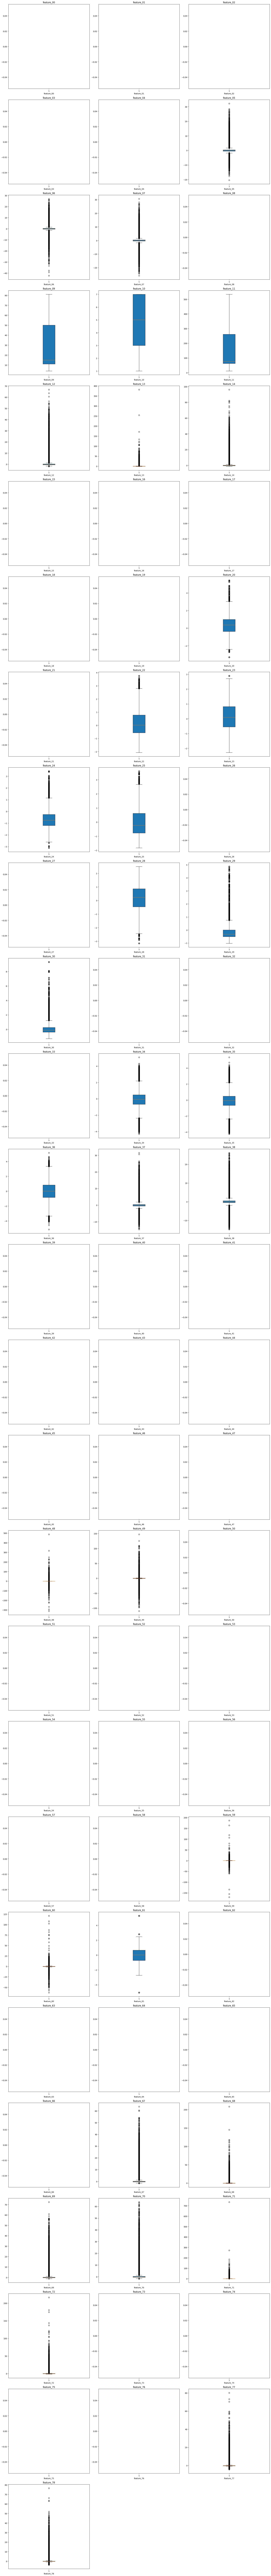

In [35]:
plot_cols_boxplots(date_and_feature(df_early_model).drop('date_id'))

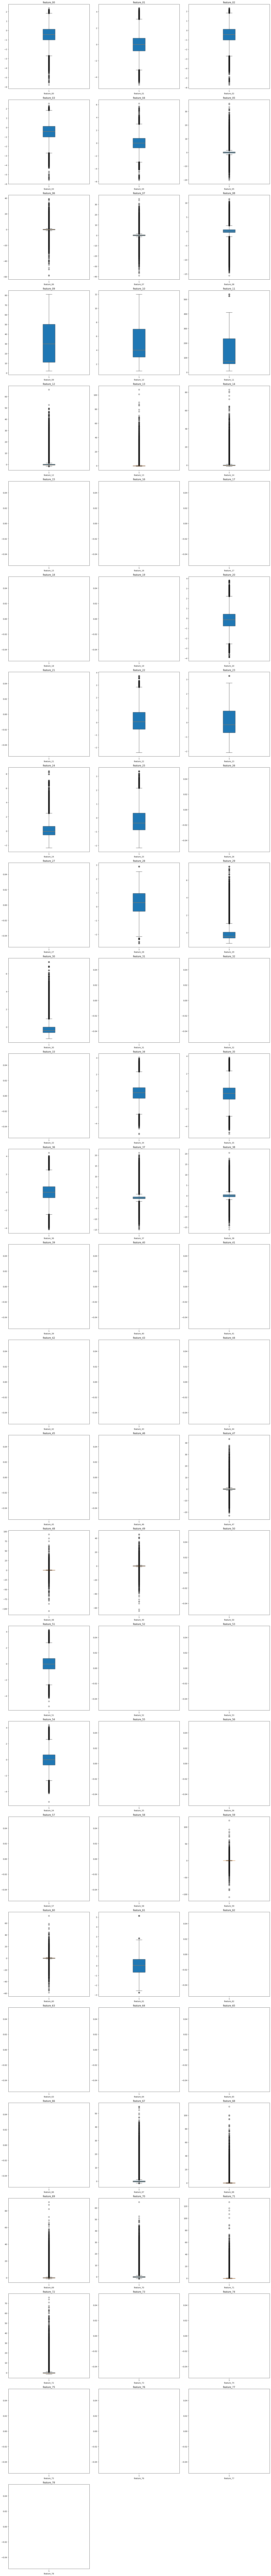

In [36]:
plot_cols_boxplots(date_and_feature(df_mid_model).drop('date_id'))

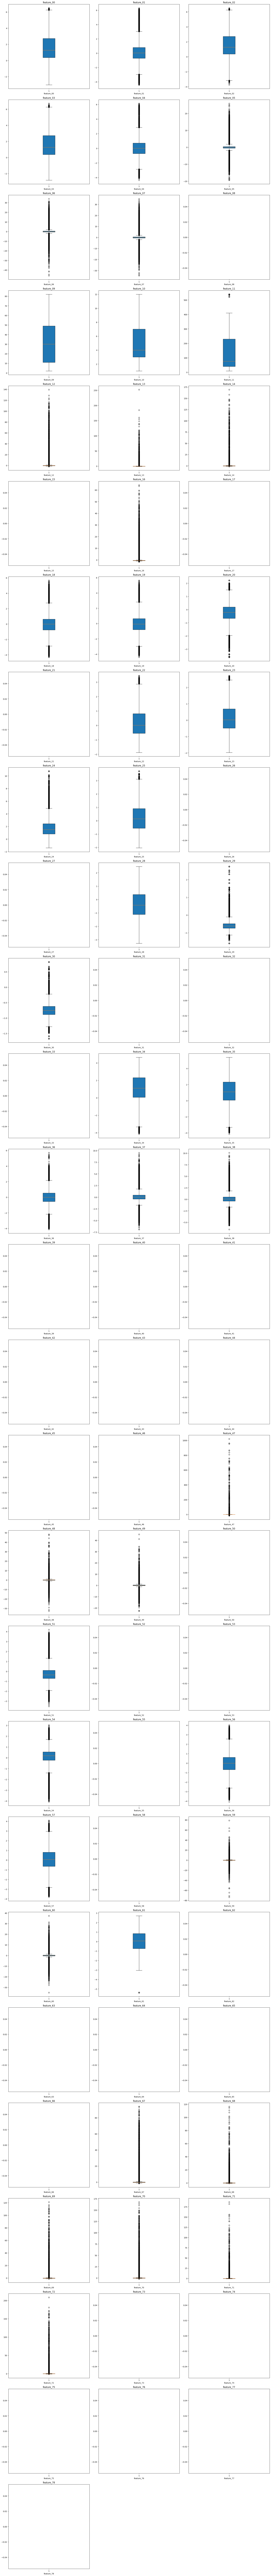

In [37]:
plot_cols_boxplots(date_and_feature(df_late_model).drop('date_id'))

# Responders_Overlook

In [23]:
responders_columns = ['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5',
                      'responder_6', 'responder_7', 'responder_8', 'weight']

dfs = []

for i in range(0,10,1):
    df = pl.read_parquet(f'datasets/train.parquet/partition_id={i}', columns=responders_columns)
    dfs.append(df)
    

df_resp_total = pl.concat(dfs)
df_resp_total.shape

(47127338, 10)

In [24]:
df_resp_total = df_resp_total.to_pandas()

df_all_weight = df_resp_total.pop('weight')
df_just_responders = df_resp_total

In [25]:
plot_dendrogram(df_just_responders)

MemoryError: Unable to allocate 3.16 GiB for an array with shape (9, 47127338) and data type float64

In [26]:
df_just_responders_weighted = df_just_responders.mul(df_all_weight.iloc[:, 0], axis=0)
df_just_responders_weighted

IndexingError: Too many indexers

In [36]:
plot_dendrogram(df_just_responders_weighted)

NameError: name 'df_just_responders_weighted' is not defined

# Statistics View

In [28]:
#!pip install umap-learn -qq
import umap

# KMeans 임포트
from sklearn.cluster import KMeans

# Umap 사용
dat_sne = df_just_responders

# UMAP 적용
umap_reducer = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=5,  # 데이터 크기가 작으므로 n_neighbors 값을 줄임
    min_dist=0.1
)
umap_result = umap_reducer.fit_transform(dat_sne)

# K-means 클러스터링 적용
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(umap_result)  # umap_result로 클러스터링

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    'UMAP_1': umap_result[:, 0],
    'UMAP_2': umap_result[:, 1],
    'Cluster': clusters
})
result_df.index = dat_sne.index  # dat_sne의 인덱스 사용

# 시각화
plt.figure(figsize=(15, 10))
scatter = sns.scatterplot(
    data=result_df,
    x='UMAP_1',
    y='UMAP_2',
    hue='Cluster',
    palette='Set1',
    s=100
)

# 레이블 표시
for idx, row in result_df.iterrows():
    plt.annotate(f"{idx[0]}-{idx[1]}", 
                (row['UMAP_1'], row['UMAP_2']), 
                xytext=(5, 5), 
                textcoords='offset points', 
                fontsize=8, 
                alpha=0.7)

plt.title('UMAP with K-means Clustering of Age, Sex group by Pay-Pattern')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 각 클러스터의 특징 분석
print("\n=== 각 클러스터의 특징 ===\n")
for cluster in range(3):  # 3개 클러스터로 수정
    cluster_members = result_df[result_df['Cluster'] == cluster].index
    cluster_means = dat_sne.loc[cluster_members].mean()
    
    print(f"\nCluster {cluster} 특징:")
    print(f"포함된 집단 수: {len(cluster_members)}")
    print("\n주요 업종 비율:")
    for category, ratio in cluster_means.sort_values(ascending=False).items():
        print(f"{category}: {ratio:.1%}")
    
    print("\n대표적인 그룹:")
    print(", ".join([f"{idx[0]}-{idx[1]}" for idx in cluster_members[:5]]))
    print("-" * 50)

# 시각화 - Stacked Bar Plot 사용
print("\n\n각 클러스터별 평균 업종 비율:")

# 각 클러스터별 평균 업종 비율 계산
cluster_means = []
for cluster in range(3):
    cluster_members = result_df[result_df['Cluster'] == cluster].index
    cluster_mean = dat_sne.loc[cluster_members].mean()
    cluster_means.append(cluster_mean)

# DataFrame으로 변환
cluster_means_df = pd.DataFrame(cluster_means, index=[f'Cluster {i}' for i in range(3)])

# Stacked Bar Plot 그리기
plt.figure(figsize=(12, 8))
cluster_means_df.plot(kind='bar', stacked=True)
plt.title('클러스터별 업종 비율 분포')
plt.xlabel('클러스터')
plt.ylabel('비율')
plt.legend(title='업종', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 1.58 GiB for an array with shape (9, 47127338) and data type float32

: 